# HPO of XGBoost with Optuna and Dask

In [1]:
from datetime import datetime
import joblib
import uuid

from distributed import Client
import dask.dataframe as dd
import coiled

import dask
import numpy as np
import pandas as pd
import optuna
from dask_ml.metrics import mean_squared_error
import xgboost as xgb
from xgboost.dask import DaskDMatrix

import dask.dataframe as dd
import matplotlib.pyplot as plt

In [2]:
ACCOUNT="dask-engineering"                                                        # <-- This is your account
FILEPATH="s3://coiled-datasets/prefect-dask/nyc-uber-lyft/feature_table.parquet"  # <-- Location of the feature table
WORKER_INSTANCE_TYPE = "m6i.xlarge"                                               # <-- EC2 instance size
CLUSTERS = {}    # Dict for collecting clusters for shutting down when done
N_WORKERS=20

In [3]:
cluster = coiled.Cluster(
    worker_vm_types=[WORKER_INSTANCE_TYPE],
    scheduler_vm_types=["m6i.2xlarge"],
    package_sync=True, # copy local packages
    shutdown_on_close=True,
    show_widget=False,
    n_workers=N_WORKERS,
    use_best_zone=True,
    account=ACCOUNT,
    backend_options={"region": "us-east-2", "spot": True},
    scheduler_options={"idle_timeout": "5 minutes"},
    )

### Train Model

In [4]:
# Here we subset data for cross-validation
def make_cv_splits(df, num_folds):
    frac = [1 / num_folds]*num_folds
    splits = df.random_split(frac, shuffle=True)
    for i in range(num_folds):
        train = [splits[j] for j in range(num_folds) if j != i]
        test = splits[i]
        yield train, test

In [5]:
def train_model(cluster, trial_number, study_params, n_splits=5):

    with Client(cluster) as client:
        # Load and pre-process the DataFrame
        ddf = dd.read_parquet(FILEPATH)
        categorical_vars = ddf.select_dtypes(include="category").columns.tolist()
        ddf = ddf.categorize(columns=categorical_vars)                    # We need to categories to be `known`
        float_cols = ddf.select_dtypes(include="float").columns.tolist()
        ddf[float_cols] = ddf[float_cols].astype(np.float32).persist()    # Under the hood, XGBoost converts floats to `float32`
        
        val_scores = []

        for train, test in make_cv_splits(ddf, n_splits):
            train = dd.concat(train)

            y_train = train['trip_time'].to_frame().persist()
            X_train = train.drop(columns=['trip_time']).persist()
            
            # Make the test data
            y_test = test['trip_time'].to_frame().persist()
            X_test = test.drop(columns='trip_time').persist()

            dtrain = DaskDMatrix(client, X_train, y_train, enable_categorical=True)

            model = xgb.dask.train(
                client,
                {'tree_method': 'hist', **study_params},
                dtrain,
                num_boost_round=4,
                evals=[(dtrain, "train")],
            )

            predictions = xgb.dask.predict(client, model, X_test)

            score = mean_squared_error(y_test.to_dask_array(lengths=True).reshape(-1,), 
                                       predictions.to_dask_array(lengths=True), squared=False
                                      )
            val_scores.append(score)
        return np.mean(val_scores)

In [6]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 75, 125),
        'learning_rate': trial.suggest_float('learning_rate', 0.5, 0.7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'max_depth': trial.suggest_int('max_depth', 1, 6),
        'max_leaves': trial.suggest_int('max_leaves', 0, 2),
        'max_cat_to_onehot': trial.suggest_int('max_cat_to_onehot', 1, 10),
    }
    rmse = train_model(
        cluster = cluster,
        trial_number=trial.number,
        study_params=params, 
    )
    return rmse

In [7]:
# Create a single study and run some trials
start = datetime.now()
study = optuna.create_study(study_name="nyc-travel-time-model")    
study.optimize(objective, n_trials=5)

print(f"Total time:  {datetime.now() - start}")

[I 2023-01-15 20:04:51,617] A new study created in memory with name: nyc-travel-time-model
[I 2023-01-15 20:10:08,579] Trial 0 finished with value: 437.55207938999774 and parameters: {'n_estimators': 96, 'learning_rate': 0.5639522213767011, 'colsample_bytree': 0.752328631700409, 'colsample_bynode': 0.9163757984451448, 'colsample_bylevel': 0.927004139602301, 'reg_lambda': 0.4694532093025502, 'max_depth': 2, 'max_leaves': 0, 'max_cat_to_onehot': 5}. Best is trial 0 with value: 437.55207938999774.
[I 2023-01-15 20:15:17,567] Trial 1 finished with value: 673.4884437141166 and parameters: {'n_estimators': 97, 'learning_rate': 0.5877532503176811, 'colsample_bytree': 0.8991330873775201, 'colsample_bynode': 0.5745533506310005, 'colsample_bylevel': 0.6186691720204036, 'reg_lambda': 0.9813511600924338, 'max_depth': 3, 'max_leaves': 1, 'max_cat_to_onehot': 10}. Best is trial 0 with value: 437.55207938999774.
[I 2023-01-15 20:20:37,999] Trial 2 finished with value: 673.1336985266744 and parameters

Total time:  0:27:13.840619


In [8]:
len(study.trials)

5

In [9]:
cluster.shutdown()

In [10]:
study.best_params

{'n_estimators': 102,
 'learning_rate': 0.5666914595972646,
 'colsample_bytree': 0.5282026274475145,
 'colsample_bynode': 0.6365873712722809,
 'colsample_bylevel': 0.8377164965815664,
 'reg_lambda': 0.06954852981351578,
 'max_depth': 6,
 'max_leaves': 0,
 'max_cat_to_onehot': 5}

In [11]:
study.best_value

408.9321111954783

In [12]:
study.best_trial

FrozenTrial(number=4, state=TrialState.COMPLETE, values=[408.9321111954783], datetime_start=datetime.datetime(2023, 1, 15, 20, 25, 48, 531253), datetime_complete=datetime.datetime(2023, 1, 15, 20, 32, 5, 457139), params={'n_estimators': 102, 'learning_rate': 0.5666914595972646, 'colsample_bytree': 0.5282026274475145, 'colsample_bynode': 0.6365873712722809, 'colsample_bylevel': 0.8377164965815664, 'reg_lambda': 0.06954852981351578, 'max_depth': 6, 'max_leaves': 0, 'max_cat_to_onehot': 5}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=125, log=False, low=75, step=1), 'learning_rate': FloatDistribution(high=0.7, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bynode': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bylevel': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'reg_lambda': FloatDistribution(high=1.0, log=Fa

In [13]:
# Uncomment this if you want to save the results of your study to examine later.
joblib.dump(study, "data/study_single_cluster.pkl")

['data/study_single_cluster.pkl']

/var/folders/b5/f_y899x168j7cs2m7szjld5c0000gn/T/ipykernel_3710/2760270799.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


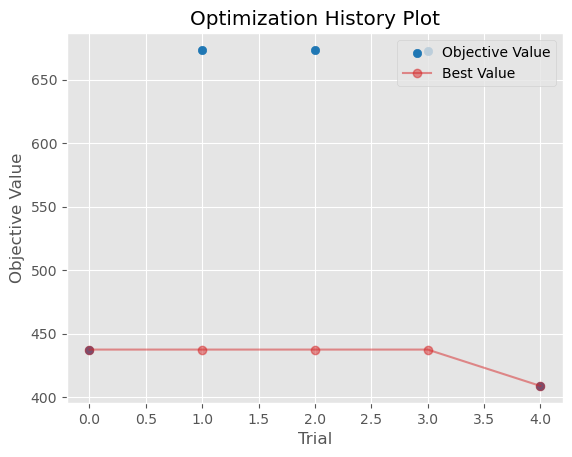

In [14]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)
fig.legend(loc="upper right")
plt.savefig("data/optimization_history_study_1.png")